## **THE DATASET ORGANIZATION**

In [2]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import timm
import os
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder

In [3]:
# Training transformations with augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Validation transformations (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
import os
import shutil
import pandas as pd

# Define dataset paths
dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000/'
image_dirs = [
    os.path.join(dataset_path, 'HAM10000_images_part_1'),
    os.path.join(dataset_path, 'HAM10000_images_part_2')
]
metadata_path = os.path.join(dataset_path, 'HAM10000_metadata.csv')

# Load metadata
metadata = pd.read_csv(metadata_path)
print(metadata.head())  # Display metadata to understand structure

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [5]:
# Create output directory
organized_dataset_path = '/kaggle/working/organized_dataset'
os.makedirs(organized_dataset_path, exist_ok=True)

# Create class-specific folders
for label in metadata['dx'].unique():
    os.makedirs(os.path.join(organized_dataset_path, label), exist_ok=True)

# Move images into corresponding class folders
for _, row in metadata.iterrows():
    image_id = row['image_id']
    label = row['dx']

    # Find the image in either directory
    src_path = None
    for image_dir in image_dirs:
        potential_path = os.path.join(image_dir, image_id + '.jpg')
        if os.path.exists(potential_path):
            src_path = potential_path
            break

    # Copy image to the organized directory
    if src_path:
        dst_path = os.path.join(organized_dataset_path, label, image_id + '.jpg')
        shutil.copy(src_path, dst_path)

In [9]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.9/269.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.5/303.5 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.15
    Uninstalling albumentations-1.4.15:
      Successfully uninstalled albumentations-1.4.15
Note: you may need to restart the kernel to use updated packages.


# **Step 1: Import Libraries**

In [13]:
import os
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm


# **Step 2: Advanced Data Augmentation**

In [15]:
# Define training transformations with advanced augmentations
train_transform = A.Compose([
    A.RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=3, p=0.5),
        A.Sharpen(p=0.5),
        A.CoarseDropout(max_holes=1, max_height=30, max_width=30, p=0.5),  # Fixed here
    ], p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Define validation transformations (no augmentation)
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


# **Step 3: Load and Preprocess the Dataset**

In [16]:
# Define dataset paths
dataset_path = '/kaggle/working/organized_dataset'
full_dataset = ImageFolder(root=dataset_path)

# Stratified split into training and validation indices
train_indices, val_indices = train_test_split(
    list(range(len(full_dataset))),
    stratify=[sample[1] for sample in full_dataset.samples],
    test_size=0.2,
    random_state=42,
)

# Create subsets with transformations
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = np.array(image)  # Convert PIL to NumPy array for Albumentations
            image = self.transform(image=image)['image']
        return image, label

train_dataset = AlbumentationsDataset(full_dataset, train_indices, transform=train_transform)
val_dataset = AlbumentationsDataset(full_dataset, val_indices, transform=val_transform)

# Compute class weights for WeightedRandomSampler
class_counts = [len([i for i in train_indices if full_dataset.samples[i][1] == c]) for c in range(len(full_dataset.classes))]
class_weights = 1.0 / np.array(class_counts)
sample_weights = [class_weights[label] for _, label in train_dataset]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


# **Step 4: Define the Hybrid Model**

In [17]:
class EnhancedHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedHybridModel, self).__init__()
        
        # EfficientNet Backbone
        self.efficientnet = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        efficientnet_out_features = self.efficientnet.num_features
        
        # ResNet Backbone
        self.resnet = timm.create_model('resnet50', pretrained=True, num_classes=0)
        resnet_out_features = self.resnet.num_features
        
        # Attention Layer
        self.attention = nn.Sequential(
            nn.Linear(efficientnet_out_features + resnet_out_features, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
        # Fully connected classification layer
        self.classifier = nn.Linear(efficientnet_out_features + resnet_out_features, num_classes)

    def forward(self, x):
        # Extract features from EfficientNet
        efficientnet_features = self.efficientnet(x)
        
        # Extract features from ResNet
        resnet_features = self.resnet(x)
        
        # Concatenate features
        combined_features = torch.cat((efficientnet_features, resnet_features), dim=1)
        
        # Apply attention
        attention_weights = self.attention(combined_features)
        combined_features = combined_features * attention_weights
        
        # Pass through the classifier
        output = self.classifier(combined_features)
        return output


# **Step 5: Focal Loss**

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss


# **Step 6: Training Setup**

In [19]:
# Initialize model, loss, optimizer, and scheduler
num_classes = len(full_dataset.classes)
model = EnhancedHybridModel(num_classes=num_classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

criterion = FocalLoss(alpha=2.0, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=3):
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        
        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), '/kaggle/working/hybrid_model_best.pth')
            print("Saved best model.")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

        # Step scheduler
        scheduler.step()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1/30


100%|██████████| 251/251 [02:54<00:00,  1.44it/s]

Train Loss: 0.6838, Train Accuracy: 0.6754


Validation Loss: 0.5145, Validation Accuracy: 0.6970
Saved best model.
Epoch 2/30


100%|██████████| 251/251 [03:10<00:00,  1.32it/s]

Train Loss: 0.1825, Train Accuracy: 0.8168


Validation Loss: 0.3508, Validation Accuracy: 0.7394
Saved best model.
Epoch 3/30


100%|██████████| 251/251 [03:10<00:00,  1.32it/s]

Train Loss: 0.0984, Train Accuracy: 0.8601


Validation Loss: 0.3476, Validation Accuracy: 0.7179
Saved best model.
Epoch 4/30


100%|██████████| 251/251 [03:09<00:00,  1.32it/s]

Train Loss: 0.0448, Train Accuracy: 0.8993


Validation Loss: 0.2200, Validation Accuracy: 0.8028
Saved best model.
Epoch 5/30


100%|██████████| 251/251 [03:10<00:00,  1.32it/s]

Train Loss: 0.0270, Train Accuracy: 0.9191


Validation Loss: 0.1626, Validation Accuracy: 0.8228
Saved best model.
Epoch 6/30


100%|██████████| 251/251 [03:09<00:00,  1.32it/s]

Train Loss: 0.0170, Train Accuracy: 0.9345


Validation Loss: 0.1340, Validation Accuracy: 0.8457
Saved best model.
Epoch 7/30


100%|██████████| 251/251 [03:10<00:00,  1.32it/s]

Train Loss: 0.0156, Train Accuracy: 0.9362


Validation Loss: 0.1621, Validation Accuracy: 0.8268
Epoch 8/30


100%|██████████| 251/251 [03:09<00:00,  1.33it/s]

Train Loss: 0.0077, Train Accuracy: 0.9516


Validation Loss: 0.1480, Validation Accuracy: 0.8328
Epoch 9/30


100%|██████████| 251/251 [03:10<00:00,  1.32it/s]

Train Loss: 0.0072, Train Accuracy: 0.9574


Validation Loss: 0.1158, Validation Accuracy: 0.8542
Saved best model.
Epoch 10/30


100%|██████████| 251/251 [03:10<00:00,  1.32it/s]

Train Loss: 0.0060, Train Accuracy: 0.9574


Validation Loss: 0.1300, Validation Accuracy: 0.8452
Epoch 11/30


100%|██████████| 251/251 [03:10<00:00,  1.32it/s]

Train Loss: 0.0048, Train Accuracy: 0.9632


Validation Loss: 0.1223, Validation Accuracy: 0.8502
Epoch 12/30


100%|██████████| 251/251 [03:10<00:00,  1.31it/s]

Train Loss: 0.0052, Train Accuracy: 0.9619


Validation Loss: 0.1255, Validation Accuracy: 0.8527
Early stopping triggered.


# **Step 7: Evaluation**

Classification Report:
              precision    recall  f1-score   support

       akiec       0.92      0.68      0.78        65
         bcc       0.85      0.84      0.85       103
         bkl       0.65      0.85      0.74       220
          df       0.89      0.74      0.81        23
         mel       0.60      0.69      0.64       223
          nv       0.94      0.89      0.92      1341
        vasc       1.00      0.86      0.92        28

    accuracy                           0.85      2003
   macro avg       0.84      0.79      0.81      2003
weighted avg       0.87      0.85      0.86      2003

Confusion Matrix:
[[  44    2   16    0    1    2    0]
 [   1   87    4    1    3    7    0]
 [   3    3  187    0   10   17    0]
 [   0    0    1   17    2    3    0]
 [   0    4   26    0  153   40    0]
 [   0    6   51    1   87 1196    0]
 [   0    0    2    0    0    2   24]]


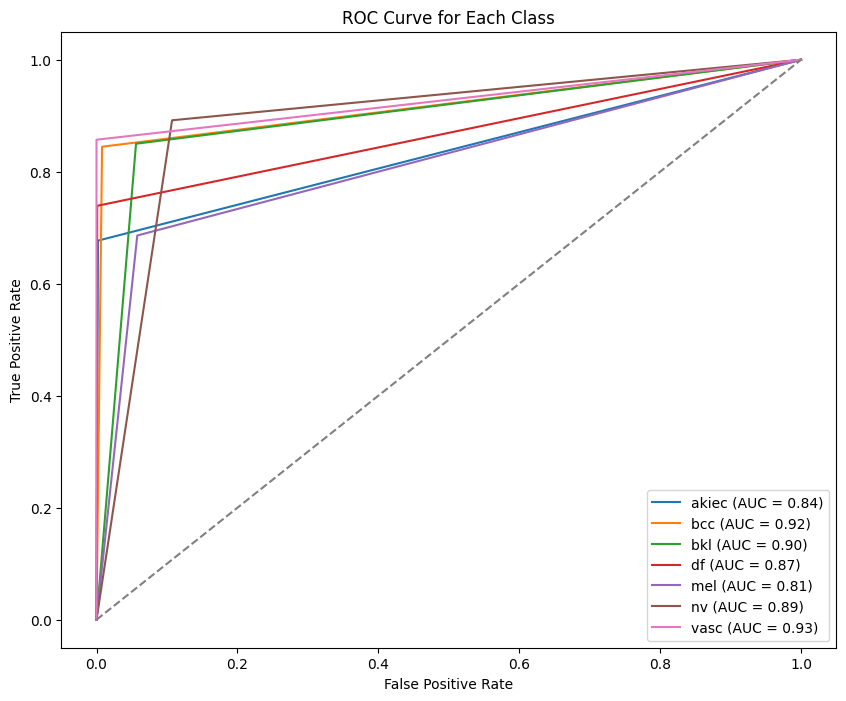

Overall Accuracy: 0.8527


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Set model to evaluation mode
model.eval()

# Collect predictions and true labels
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
class_names = full_dataset.classes  # Get class names
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# AUC and ROC Curve
# Binarize the labels for multi-class ROC/AUC
num_classes = len(class_names)
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
all_preds_bin = label_binarize(all_preds, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
    roc_auc[i] = roc_auc_score(all_labels_bin[:, i], all_preds_bin[:, i])

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

# Overall Accuracy
accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Overall Accuracy: {accuracy:.4f}")
